#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Создание признаков</a></span></li><li><span><a href="#Проверка-на-мультиколлинеарность" data-toc-modified-id="Проверка-на-мультиколлинеарность-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Проверка на мультиколлинеарность</a></span></li><li><span><a href="#Кодирование-категориальных-и-масштабирование-численных-признаков" data-toc-modified-id="Кодирование-категориальных-и-масштабирование-численных-признаков-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Кодирование категориальных и масштабирование численных признаков</a></span></li><li><span><a href="#Деление-на-выборки" data-toc-modified-id="Деление-на-выборки-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Деление на выборки</a></span></li><li><span><a href="#Качество-прогноза" data-toc-modified-id="Качество-прогноза-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Качество прогноза</a></span></li><li><span><a href="#Важное-отсупление" data-toc-modified-id="Важное-отсупление-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Важное отсупление</a></span></li><li><span><a href="#Модель-линейной-регрессии" data-toc-modified-id="Модель-линейной-регрессии-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>Модель линейной регрессии</a></span><ul class="toc-item"><li><span><a href="#Lasso" data-toc-modified-id="Lasso-3.7.1"><span class="toc-item-num">3.7.1&nbsp;&nbsp;</span>Lasso</a></span></li><li><span><a href="#Ridge" data-toc-modified-id="Ridge-3.7.2"><span class="toc-item-num">3.7.2&nbsp;&nbsp;</span>Ridge</a></span></li></ul></li><li><span><a href="#Модель-случайного-леса" data-toc-modified-id="Модель-случайного-леса-3.8"><span class="toc-item-num">3.8&nbsp;&nbsp;</span>Модель случайного леса</a></span></li><li><span><a href="#Модель-градиентного-бустинга-библиотеки-LightGBM" data-toc-modified-id="Модель-градиентного-бустинга-библиотеки-LightGBM-3.9"><span class="toc-item-num">3.9&nbsp;&nbsp;</span>Модель градиентного бустинга библиотеки LightGBM</a></span></li><li><span><a href="#Модель-линейной-регрессии-ElasticNet" data-toc-modified-id="Модель-линейной-регрессии-ElasticNet-3.10"><span class="toc-item-num">3.10&nbsp;&nbsp;</span>Модель линейной регрессии ElasticNet</a></span></li><li><span><a href="#Сопоставление-реальных-значений-заказанных-такси-и-предсказаний-моделей" data-toc-modified-id="Сопоставление-реальных-значений-заказанных-такси-и-предсказаний-моделей-3.11"><span class="toc-item-num">3.11&nbsp;&nbsp;</span>Сопоставление реальных значений заказанных такси и предсказаний моделей</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

## Подготовка

Импортируем нужные библиотеки. 

In [1]:
!pip install lightgbm -q

In [2]:
import pandas as pd
import numpy as np

import lightgbm as lgb
from lightgbm import LGBMRegressor

from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer

from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, TimeSeriesSplit

from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor

from sklearn.pipeline import Pipeline

from statsmodels.tsa.seasonal import seasonal_decompose

import statsmodels.tsa.api as smt
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

Создаем путь к файлу с данными.

In [3]:
path = '/datasets/taxi.csv'

Откроем файл с информацией об исторических данных о заказах такси в аэропортах.

In [4]:
try:
    df = pd.read_csv(
        path, 
        index_col=[0], 
        parse_dates=[0]
    )
except Exception as err:
    try:
        df = pd.read_csv(path[10:],
                         index_col=[0],
                         parse_dates=[0]
                        )
    except Exception as err:
        print('Ошибка чтения файла:', repr(err))

In [5]:
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


В таблице 26496 строк с количеством заказов такси в аэропорты, а так же информация о дате и времени заказа, которую мы, предварительно ознакомившись с данными, превратили в индекс и распознали, как тип данных `datetime64[ns]`.

По первым индексам можно сделать предположение, что **временной интервал**, с которым записывались данные, составлял **10 минут**, однако мы не знаем наверняка, отсортированы ли наши данные.

Проверим, в хронологическом ли порядке расположены даты и время.

In [7]:
df.index.is_monotonic

True

Хронологический порядок в данных соблюдён.

In [8]:
print(f'Данные в таблице от {df.index.min()} до {df.index.max()}')

Данные в таблице от 2018-03-01 00:00:00 до 2018-08-31 23:50:00


В таблице представлены данные за 6 месяцев 2018 года: от начала марта до конца августа. И данные представлены с 10-минутным интервалом. Визуализировать такое распределение будет бесполезно. 

В рамках нашего задания нам нужно предсказать количество такси в час. Произведем ресемплирование по часу с суммированием значений за каждый десятиминутный интервал.

In [9]:
df = df.resample('1H').sum()

In [10]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Анализ

Посмотрим на распределение количества заказанных в аэропорт такси за разные периоды времени:
- за 1 час (только за последний имеющийся месяц)
- за 1 день 
- за 1 неделю
- за 1 месяц.

In [11]:
fs = (14, 3)

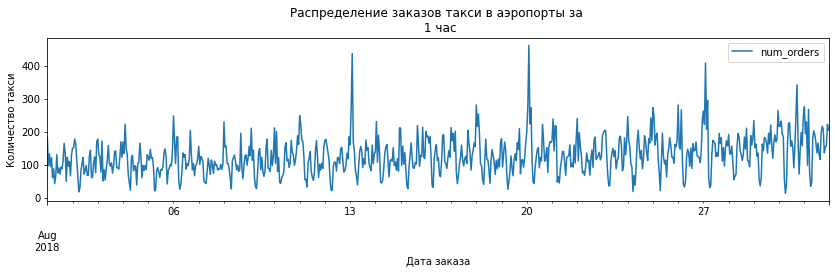

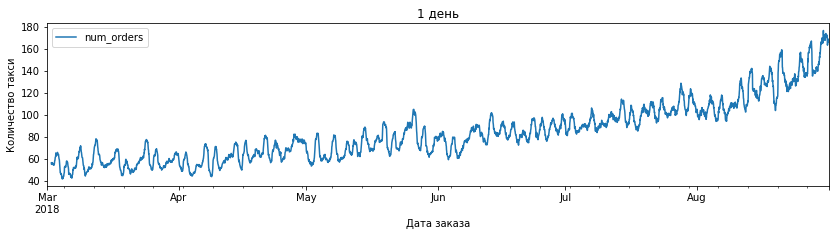

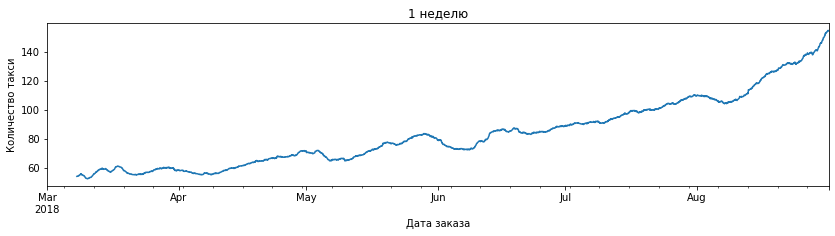

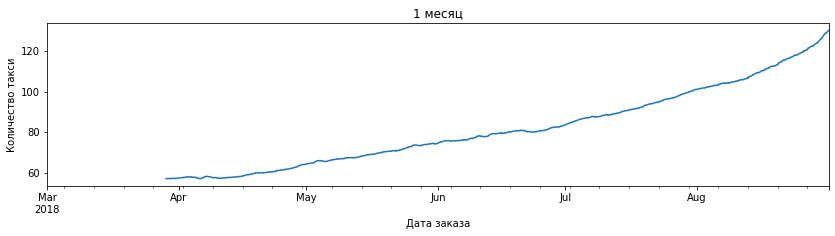

In [12]:
df['2018-08-01':'2018-08-31'].plot(figsize=fs)
plt.xlabel('Дата заказа')
plt.ylabel('Количество такси')
plt.title('Распределение заказов такси в аэропорты за \n 1 час')
plt.show()

df['num_orders'].rolling(24).mean().plot(figsize=fs)
# df['num_orders'].resample('1D').sum().plot(figsize=fs)
plt.xlabel('Дата заказа')
plt.legend()
plt.ylabel('Количество такси')
plt.title('1 день')
plt.show()

df['num_orders'].rolling(24 * 7).mean().plot(figsize=fs)
# df['num_orders'].resample('1W').sum().plot(figsize=fs)
plt.xlabel('Дата заказа')
plt.ylabel('Количество такси')
plt.title('1 неделю')
plt.show()

# df['num_orders'].resample('1M').sum().plot(figsize=fs)
df['num_orders'].rolling(24 * 7 * 4).mean().plot(figsize=fs)
plt.xlabel('Дата заказа')
plt.ylabel('Количество такси')
plt.title('1 месяц')
plt.show()

Видим, что с каждым месяцем суммарное количество заказов в аэропорты растет. Есть увеличение количества заказанных такси к концу месяца.

Разложим временной ряд на три составляющие: тренд, сезонность и остаток при помощи модуля `tsa.seasonal` библиотеки `statsmodels`. Используем функцию `seasonal_decompose()`.

In [13]:
decomposed = seasonal_decompose(df)

Посмотрим на тренд, сезонность и отстаток.

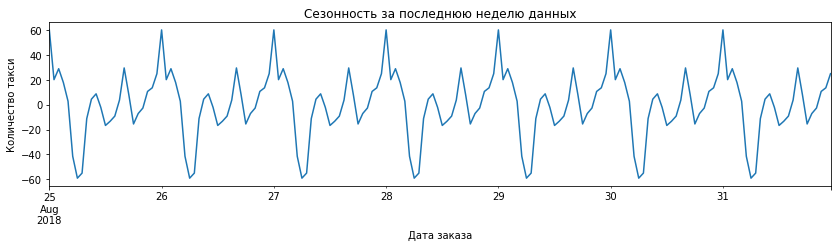

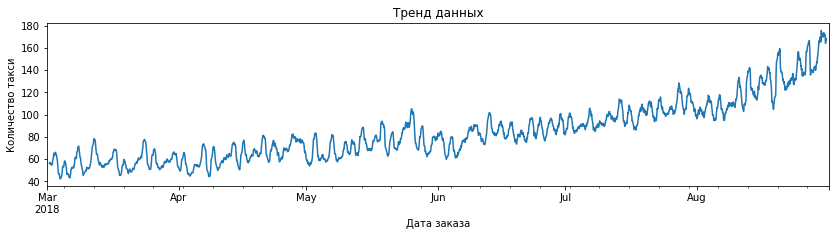

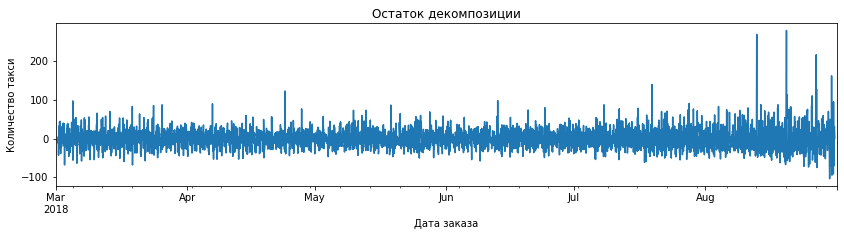

In [14]:
decomposed.seasonal['2018-08-25':'2018-08-31'].plot(figsize=fs)
plt.xlabel('Дата заказа')
plt.ylabel('Количество такси')
plt.title('Сезонность за последнюю неделю данных')
plt.show()

decomposed.trend.plot(figsize=fs)
plt.xlabel('Дата заказа')
plt.ylabel('Количество такси')
plt.title('Тренд данных')
plt.show()

decomposed.resid.plot(figsize=fs)
plt.xlabel('Дата заказа')
plt.ylabel('Количество такси')
plt.title('Остаток декомпозиции')
plt.show()

**Отстаток декомпозиции** невозможно интерпретировать, **тренд** данных показывает **склонность к росту количества заказов с каждым месяцем**, удивительным образом оказавшись одинаковым с графиком скользящей средней с интервалом в сутки. 

**Сезонность** показала, что количество заказов за сутки меняется с особой периодичностью: **существуют утренние, дневные и особенно вечерние часы, в которые количество заказов имеет пиковое значение. Ночью в аэропорты ездят реже всего**. 

In [15]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Далее, основываясь на [статье](https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python?scriptVersionId=50985180&cellId=80), проверим стационарность ряда, используя **тест Дики — Фуллера**. 

- Это методика, которая используется в прикладной статистике и эконометрике для анализа временных рядов для проверки на стационарность (наличие единичного корня). 

- Если из нестационарного ряда первыми разностями удаётся получить стационарный, то он называется интегрированным первого порядка. 

- [Основная идея](https://habr.com/ru/post/540868/) теста заключается в подтверждении или отклонении двух гипотез:

    - **Нулевая гипотеза** (H0): предполагает, что временной ряд имеет единичный корень, то есть он нестационарный.

    - **Альтернативная гипотеза** (H1): предполагает, что временной ряд не имеет единичного корня, то есть он является стационарным. Если эта гипотеза верна, то у нас есть список покупок подарков на определенный временной период, в котором количество подарков для близких коллег и знакомых будет неизменно.

- Для подтверждения или опровержения этих гипотез используются `p-values` значения.

    - p -values — это наименьшее значение уровня значимости (то есть вероятности отказа от справедливой гипотезы).

    - В случае если p –values больше значения 5%, то мы отвергаем нулевую гипотезу, и, следовательно, ряд является стационарным, имеет определенную периодичность, которую возможно выявить.

C:\Users\А\AppData\Roaming\Python\Python38\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


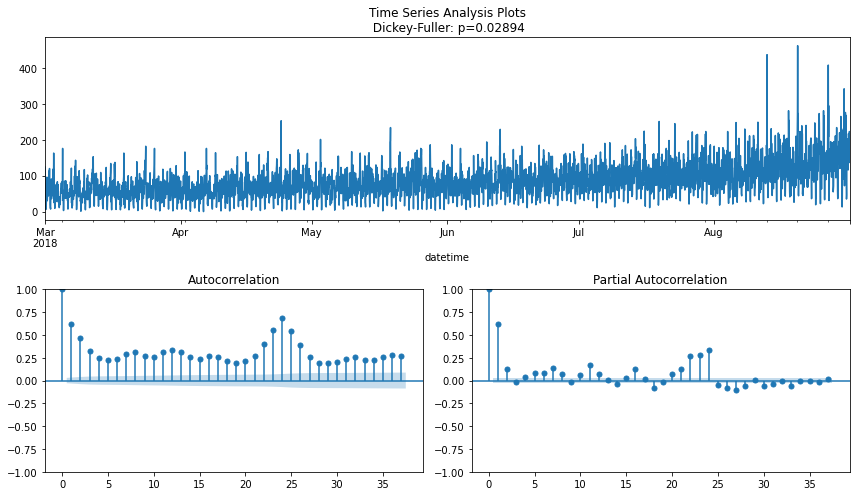

In [16]:
# from https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python?scriptVersionId=50985180&cellId=80
def tsplot(y, lags=None, figsize=(12, 7)):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
           
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()
    
tsplot(df.num_orders)

Автокорреляция показывает, что ряд не такой стационарный, как хотелось бы, однако тест Дики-Фуллера позволяет принять альтернативную гипотезу, что ряд стационарен.

## Обучение

In [17]:
# создадим копию таблицы для добавления признаков
df_with_features = df.copy()

### Создание признаков

Для обучения моделей нам понадобится вытащить из временного ряда признаки: календарные признаки, "отстающие значения", скользящее среднее. Напишем функцию для этого.

In [18]:
def make_features(data, max_lag, rolling_mean_size):
#     data['year'] = data.index.year
#     data['month'] = data.index.month
#     data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    data['rolling_mean'] = data['num_orders'].shift().rolling(
        rolling_mean_size).mean()

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

В [статье](https://habr.com/ru/post/584896/) пишут, что в практических задачах работает количество "отстающих значений" диапазоне от 4 до 12.
    
Возьмем пару лагов (значения за предыдущий час и за час до него) и скользящее среднее 24 (среднее за сутки).

In [19]:
make_features(df_with_features, 2, 24)

In [20]:
df_with_features.head()

,num_orders,dayofweek,hour,rolling_mean,lag_1,lag_2
datetime,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,NaN,124.0,NaN
2018-03-01 02:00:00,71,3,2,NaN,85.0,124.0
2018-03-01 03:00:00,66,3,3,NaN,71.0,85.0
2018-03-01 04:00:00,43,3,4,NaN,66.0,71.0


Избавимся от строк с пропусками.

In [21]:
df_with_features = df_with_features.dropna()

### Проверка на мультиколлинеарность

Проверим данные на мультиколлинеарность.

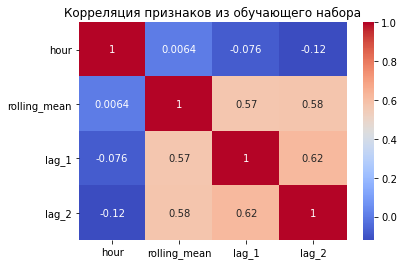

In [22]:
# var_corr = features_train.iloc[:, 0:20].corr()
var_corr = df_with_features.drop(['num_orders', 'dayofweek'], axis=1).corr()

sns.heatmap(var_corr, 
            xticklabels=var_corr.columns, 
            yticklabels=var_corr.columns, 
            cmap= 'coolwarm',
            annot=True
           )
plt.title('Корреляция признаков из обучающего набора')
plt.show()

Видим взаимосвязь между "отстающими значениями", однако корреляции между признаками выше 0.9 не было обнаружено.

### Кодирование категориальных и масштабирование численных признаков

In [23]:
# копия для модели градиентного бустинга
df_for_gb = df_with_features.copy()

Создадим спискок колонок для масштабирования.

In [24]:
df_with_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4392 entries, 2018-03-02 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4392 non-null   int64  
 1   dayofweek     4392 non-null   int64  
 2   hour          4392 non-null   int64  
 3   rolling_mean  4392 non-null   float64
 4   lag_1         4392 non-null   float64
 5   lag_2         4392 non-null   float64
dtypes: float64(3), int64(3)
memory usage: 240.2 KB


In [25]:
categorical_to_ohe = ['dayofweek', 'hour']

In [26]:
df_with_features = pd.get_dummies(df_with_features, columns=categorical_to_ohe, drop_first=True)

Масштабируем данные, хранящиеся в выборках, используя стандартизацию.

Создадим объект структуры `StandardScaler`.


In [27]:
scaler = StandardScaler()

Далее мы используем его в `Pipeline`.

Мы намеренно избежали добавления кодирования признаков в `Pipeline`, так как при первой подобной попытке оказалось, что во время кросс-валидации модель обучается на выборке с одним набором признаков, а потом должна предсказать модель с другим набором признаков (появился новый месяц или день недели).

### Деление на выборки

Cоздадим обучающую (`_train`), валидационную (`_valid`) и тестовую (`_test`) выборки. Перемешивать выборки в задаче прогнозирования временного ряда нельзя. Данные обучающей выборки должны предшествовать данным тестовой. Иначе тестирование модели будет некорректным: модель не должна обучаться на данных из будущего.

In [28]:
# выборки для моделей линейной регрессии и случайного леса (с OHE)
train_valid, test = train_test_split(df_with_features, shuffle=False, test_size=0.1)

train, valid = train_test_split(train_valid, shuffle=False, test_size = 0.2)

features_train = train.drop('num_orders', axis=1)
features_valid = valid.drop('num_orders', axis=1)
features_test = test.drop('num_orders', axis=1)

features_train_valid = train_valid.drop('num_orders', axis=1)


target_train = train['num_orders']
target_valid = valid['num_orders']
target_test = test['num_orders']

target_train_valid = train_valid['num_orders']

# выборки для модели градиентного бустинга (без OHE)

for column in categorical_to_ohe:
    df_for_gb[column] = pd.Series(df_for_gb[column], dtype='category')

train_valid_gb, test_gb = train_test_split(df_for_gb, shuffle=False, test_size=0.1)

train_gb, valid_gb = train_test_split(train_valid_gb, shuffle=False, test_size = 0.2)

features_train_gb = train_gb.drop('num_orders', axis=1)
features_valid_gb = valid_gb.drop('num_orders', axis=1)
features_test_gb = test_gb.drop('num_orders', axis=1)

features_train_valid_gb = train_valid_gb.drop('num_orders', axis=1)

Оценим размеры выборок:

In [29]:
features_train.shape, features_valid.shape, features_test.shape, target_train.shape, target_valid.shape, target_test.shape, \
features_train_valid.shape, target_train_valid.shape

((3161, 32),
 (791, 32),
 (440, 32),
 (3161,),
 (791,),
 (440,),
 (3952, 32),
 (3952,))

### Качество прогноза

Для обучения моделей нам понадобится оценить качество прогноза. 

У нас есть четкое **требование к качеству**: значение метрики `RMSE` на тестовой выборке должно быть **не больше 48**.

Таким образом, спрогнозировать временные ряды без обучения можно двумя способами:
1. Все значения тестовой выборки предсказываются одним и тем же числом (константой). Для метрики `RMSE` — это среднее значение.
2. Новое значение x(t) прогнозируется предыдущим значением ряда, то есть x(t-1), этот способ не зависит от метрики.

Создадим функцию, рассчитывающую значение метрики `RMSE`.

In [30]:
def rmse(target, predictions):
    result = mean_squared_error(target, predictions, squared=False)
    return result

Оценим прогноз константой - средним значением.

In [31]:
print(f'Среднее количество выызваемых в аэропорты такси в час: {target_train.mean():.0f}')

Среднее количество выызваемых в аэропорты такси в час: 71


In [32]:
predictions_mean = pd.Series(target_train.mean(), index=target_valid.index)
print(f'RMSE прогноза константой: {rmse(target_valid, predictions_mean):.0f}')

RMSE прогноза константой: 55


Оценим прогноз предыдущим значением ряда.

In [33]:
predictions_previous = target_valid.shift(fill_value=target_train.iloc[-1])
print(f'RMSE прогноза предыдущим значением ряда: {rmse(target_valid, predictions_previous):.0f}')

RMSE прогноза предыдущим значением ряда: 46


Неплохо. Наши значения на тестовой выборке должны оказаться не выше 48. Проверим.

In [34]:
predictions_previous_2 = target_test.shift(fill_value=target_train_valid.iloc[-1])
print(f'RMSE прогноза предыдущим значением ряда: {rmse(target_test, predictions_previous_2):.0f}')

RMSE прогноза предыдущим значением ряда: 59


Предсказывать предыдущим значением ряда не выйдет.

Внесем данные в результирующую табличку.

In [35]:
results = pd.DataFrame(columns=['valid_RMSE'])
results.loc['constant', 'valid_RMSE'] = round(rmse(target_valid, predictions_mean))
results.loc['previous', 'valid_RMSE'] = round(rmse(target_valid, predictions_previous))

Превратим метрику RMSE в `scorer`, который можно использовать как параметр функции `cross_val_score`. 

In [36]:
rmse_score = make_scorer(
    rmse, 
    greater_is_better=False
)

Обучим несколько моделей.
<!-- и оценим их качество кросс-валидацией. -->

### Важное отсупление
**В рамках данной работы сразу сделаем важное отступление. Модели считаются достаточно медленно, поэтому в каждой модели были перебраны разные гиперпараметры, которые впоследствии в коде были сокращены для увеличения скорости отработки тетради.**

### Модель линейной регрессии

Возьмем для исследования пару моделей линейной регрессии:
- Lasso
- Ridge


#### Lasso

Построим пайплайн для модели Lasso.

In [37]:
state = 12345

In [38]:
pipe_lasso = Pipeline([
    ('scaler', scaler),
    ('model', Lasso(random_state=state, max_iter=100))

])

params_lasso = [
    {
        'model': [Lasso(random_state=state)],
#         'model__alpha': np.logspace(-3, 1, 10), # параметры при подборе
        'model__alpha': [0.001], # параметры после подбора
    },
]

tscv = TimeSeriesSplit(n_splits=8) 


grid_lasso = GridSearchCV(pipe_lasso, param_grid=params_lasso, cv=tscv, n_jobs=-1, scoring=rmse_score, verbose=2)

grid_lasso.fit(features_train_valid, target_train_valid)

Fitting 8 folds for each of 1 candidates, totalling 8 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        Lasso(max_iter=100,
                                              random_state=12345))]),
             n_jobs=-1,
             param_grid=[{'model': [Lasso(alpha=0.001, random_state=12345)],
                          'model__alpha': [0.001]}],
             scoring=make_scorer(rmse, greater_is_better=False), verbose=2)

In [39]:
lasso_rmse = -grid_lasso.best_score_
print('Best Params:', grid_lasso.best_params_)
print()
print('Best RMSE Score:', lasso_rmse)

Best Params: {'model': Lasso(alpha=0.001, random_state=12345), 'model__alpha': 0.001}

Best RMSE Score: 24.961091741704998


Кросс-валидацией нашли лучшую модель, сохраним ее.

In [40]:
lasso_model = grid_lasso.best_estimator_
lasso_model.fit(features_train, target_train)
lasso_predicts = lasso_model.predict(features_valid)
rmse_lasso = rmse(target_valid, lasso_predicts)
print(f'RMSE для модели Lasso {rmse_lasso:.2f} такси')

RMSE для модели Lasso 31.26 такси


In [41]:
results.loc['lasso', 'valid_RMSE'] = round(rmse_lasso, 2)

In [42]:
results

,valid_RMSE
constant,55
previous,46
lasso,31.26


Модель предсказала лучше, чем константные модели.

#### Ridge

Построим пайплайн для модели Ridge.

In [43]:
pipe_ridge = Pipeline([
    ('scaler', scaler),
    ('model', Ridge(random_state=state, max_iter=1000))

])

params_ridge = [
    {
        'model': [Ridge(random_state=state, max_iter=1000)],
#         'model__alpha': [0.01, 0.1, 0.5, 1, 5, 10, 20, 40], # параметры при подборе
        'model__alpha': [0.01], # параметры после подбора
    },
]

grid_ridge = GridSearchCV(pipe_ridge, param_grid=params_ridge, cv=tscv, n_jobs=-1, scoring=rmse_score, verbose=2)

grid_ridge.fit(features_train_valid, target_train_valid)

Fitting 8 folds for each of 1 candidates, totalling 8 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        Ridge(max_iter=1000,
                                              random_state=12345))]),
             n_jobs=-1,
             param_grid=[{'model': [Ridge(alpha=0.01, max_iter=1000,
                                          random_state=12345)],
                          'model__alpha': [0.01]}],
             scoring=make_scorer(rmse, greater_is_better=False), verbose=2)

In [44]:
ridge_rmse = -grid_ridge.best_score_
print('Best Params:', grid_ridge.best_params_)
print()
print('Best RMSE Score:', ridge_rmse)

Best Params: {'model': Ridge(alpha=0.01, max_iter=1000, random_state=12345), 'model__alpha': 0.01}

Best RMSE Score: 24.9589537473036


Кросс-валидацией нашли лучшую модель, сохраним ее.

In [45]:
ridge_model = grid_ridge.best_estimator_
ridge_model.fit(features_train, target_train)
ridge_predicts = ridge_model.predict(features_valid)
rmse_ridge = rmse(target_valid, ridge_predicts)
print(f'RMSE для модели Ridge {rmse_ridge:.2f} такси')

RMSE для модели Ridge 31.25 такси


In [46]:
results.loc['ridge', 'valid_RMSE'] = round(rmse_ridge, 2)

In [47]:
results

,valid_RMSE
constant,55
previous,46
lasso,31.26
ridge,31.25


### Модель случайного леса

Построим пайплайн для модели случайного леса.

In [48]:
pipe_forest = Pipeline([
    ('scaler', scaler),
    ('model', RandomForestRegressor(random_state=state, n_jobs=-1))

])

params_forest = [
    {
        'model': [RandomForestRegressor(random_state=state)],
#         'model__n_estimators': list(range(1, 200, 20)), # параметры при подборе
        'model__n_estimators': [161], # параметры после подбора

#         'model__max_depth': list(range(2, 10, 1)), # параметры при подборе
        'model__max_depth': [9], # параметры после подбора
    },
]

grid_forest = GridSearchCV(pipe_forest, param_grid=params_forest, cv=tscv, n_jobs=-1, scoring=rmse_score, verbose=3)

grid_forest.fit(features_train_valid, target_train_valid)

Fitting 8 folds for each of 1 candidates, totalling 8 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        RandomForestRegressor(n_jobs=-1,
                                                              random_state=12345))]),
             n_jobs=-1,
             param_grid=[{'model': [RandomForestRegressor(max_depth=9,
                                                          n_estimators=161,
                                                          random_state=12345)],
                          'model__max_depth': [9],
                          'model__n_estimators': [161]}],
             scoring=make_scorer(rmse, greater_is_better=False), verbose=3)

In [49]:
forest_rmse = -grid_forest.best_score_
print('Best Params:', grid_forest.best_params_)
print()
print('Best RMSE Score:', forest_rmse)

Best Params: {'model': RandomForestRegressor(max_depth=9, n_estimators=161, random_state=12345), 'model__max_depth': 9, 'model__n_estimators': 161}

Best RMSE Score: 27.242404473681148


Кросс-валидацией нашли лучшую модель, сохраним ее.

In [50]:
forest_model = grid_forest.best_estimator_
forest_model.fit(features_train, target_train)
forest_predicts = forest_model.predict(features_valid)
rmse_forest = rmse(target_valid, forest_predicts)
print(f'RMSE для модели Random Forest {rmse_forest:.0f} такси')

RMSE для модели Random Forest 36 такси


In [51]:
results.loc['random forest', 'valid_RMSE'] = round(rmse_forest)

In [52]:
results

,valid_RMSE
constant,55
previous,46
lasso,31.26
ridge,31.25
random forest,36


### Модель градиентного бустинга библиотеки LightGBM

Так же для данной модели попробуем построить пайплайн.

In [53]:
pipe_light = Pipeline([
    ('scaler', scaler),
    ('model', LGBMRegressor(random_state=state))

])

params_light = [
    {
        'model': [LGBMRegressor(random_state=state)],
#         'model__n_estimators': list(range(1, 300, 20)), # параметры при подборе
        'model__n_estimators': [61], # параметры после подбора

#         'model__max_depth': list(range(2, 20, 2)), # параметры при подборе
        'model__max_depth': [12], # параметры после подбора
    },
]

grid_light = GridSearchCV(pipe_light, param_grid=params_light, cv=tscv, n_jobs=-1, scoring=rmse_score, verbose=2)

grid_light.fit(features_train_valid_gb, target_train_valid)

Fitting 8 folds for each of 1 candidates, totalling 8 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        LGBMRegressor(random_state=12345))]),
             n_jobs=-1,
             param_grid=[{'model': [LGBMRegressor(max_depth=12, n_estimators=61,
                                                  random_state=12345)],
                          'model__max_depth': [12],
                          'model__n_estimators': [61]}],
             scoring=make_scorer(rmse, greater_is_better=False), verbose=2)

In [54]:
light_rmse = -grid_light.best_score_
print('Best Params:', grid_light.best_params_)
print()
print('Best RMSE Score:', light_rmse)

Best Params: {'model': LGBMRegressor(max_depth=12, n_estimators=61, random_state=12345), 'model__max_depth': 12, 'model__n_estimators': 61}

Best RMSE Score: 24.304265400902807


Кросс-валидацией нашли лучшую модель, сохраним ее.

In [55]:
light_model = grid_light.best_estimator_
light_model.fit(features_train_gb, target_train)
light_predicts = light_model.predict(features_valid_gb)
rmse_light = rmse(target_valid, light_predicts)
print(f'RMSE для модели Random light {rmse_light:.0f} такси')

RMSE для модели Random light 33 такси


In [56]:
results.loc['LGBMRegressor', 'valid_RMSE'] = round(rmse_light)

In [57]:
results

,valid_RMSE
constant,55
previous,46
lasso,31.26
ridge,31.25
random forest,36
LGBMRegressor,33


Теперь взглянем на то, какое качество показали исследуемые модели.

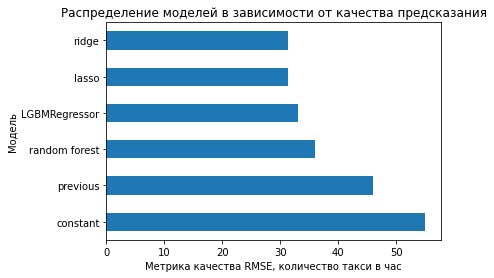

In [58]:
results['valid_RMSE'].sort_values(ascending=False).plot(kind='barh')
plt.ylabel('Модель')
plt.xlabel('Метрика качества RMSE, количество такси в час')
plt.title('Распределение моделей в зависимости от качества предсказания')
plt.show()

- Модель градиентного бустинга показала себя хуже моделей линейной регрессии, а времени на ее обучение ушло гораздо дольше. 
- Приятно видеть, что все обученные модели показали качество выше предсказания средним и предыдущим значением.


- Лучшее качество показали модели линейной регресси Ridge и Lasso. Но так как их метрики качества практически одинаковы, попробуем обучить еще одну модель, объединяющую регуляризации обоих моделей - ElasticNet. И так же посмотрим на графиках, как они отличаются в предсказаниях.

### Модель линейной регрессии ElasticNet

Построим пайплайн для модели ElasticNet.

In [59]:
pipe_elastic = Pipeline([
    ('scaler', scaler),
    ('model', ElasticNet(random_state=state, max_iter=1000))

])

params_elastic = [
    {
        'model': [ElasticNet(random_state=state, max_iter=1000)],
#         'model__alpha': [0.01, 0.1, 0.5, 1, 5, 10, 20, 40], # параметры при подборе
        'model__alpha': [0.01], # параметры после подбора
#         'model__l1_ratio': np.logspace(-5, 0, 15), # параметры при подборе
        'model__l1_ratio': [1.0], # параметры после подбора
    },
]

grid_elastic = GridSearchCV(pipe_elastic, param_grid=params_elastic, cv=tscv, n_jobs=-1, scoring=rmse_score, verbose=2)

grid_elastic.fit(features_train_valid, target_train_valid)

Fitting 8 folds for each of 1 candidates, totalling 8 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        ElasticNet(random_state=12345))]),
             n_jobs=-1,
             param_grid=[{'model': [ElasticNet(alpha=0.01, l1_ratio=1.0,
                                               random_state=12345)],
                          'model__alpha': [0.01], 'model__l1_ratio': [1.0]}],
             scoring=make_scorer(rmse, greater_is_better=False), verbose=2)

In [60]:
elastic_rmse = -grid_elastic.best_score_
print('Best Params:', grid_elastic.best_params_)
print()
print('Best RMSE Score:', elastic_rmse)

Best Params: {'model': ElasticNet(alpha=0.01, l1_ratio=1.0, random_state=12345), 'model__alpha': 0.01, 'model__l1_ratio': 1.0}

Best RMSE Score: 24.982829864382555


- Модель показала лучшую метрику качестве при L1-регуляризации, а так как у нас уже есть такая модель - Lasso, поэтому использовать модель ElasticNet нет особого смысла. 

### Сопоставление реальных значений заказанных такси и предсказаний моделей

Теперь посмотрим на графике, как справились с предсказаниями модели Lasso, Ridge и остальные.

In [61]:
print(f'Данные в валидационном наборе от {target_valid.index.min()} до {target_valid.index.max()}')

Данные в валидационном наборе от 2018-07-11 17:00:00 до 2018-08-13 15:00:00


In [62]:
lasso_predicts = pd.Series(lasso_predicts, index=features_valid.index)
ridge_predicts = pd.Series(ridge_predicts, index=features_valid.index)
forest_predicts = pd.Series(forest_predicts, index=features_valid.index)
light_predicts = pd.Series(light_predicts, index=features_valid.index)

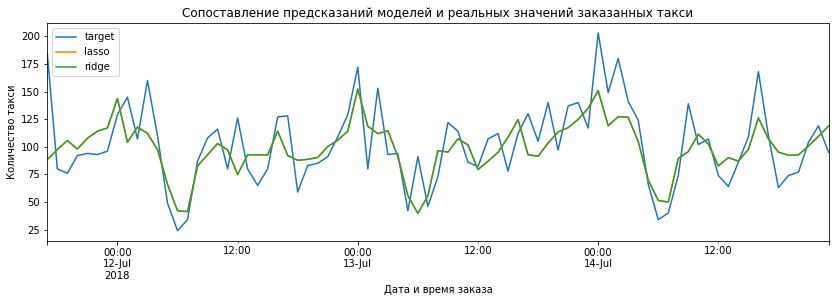

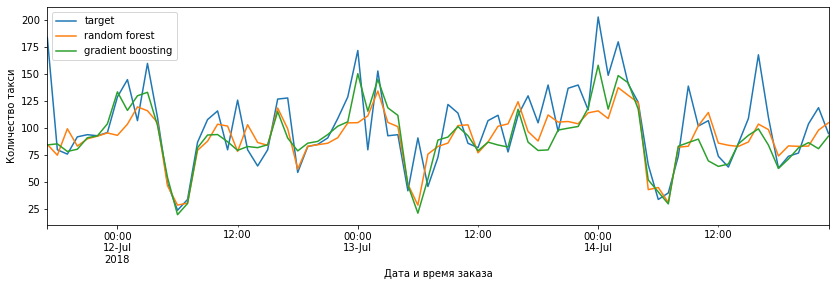

In [63]:
FG = (14, 4)
DATA_1 = '2018-07-11'
DATA_2 = '2018-07-14'

target_valid[DATA_1:DATA_2].plot(figsize=FG, label='target')
lasso_predicts[DATA_1:DATA_2].plot(figsize=FG, label='lasso')
ridge_predicts[DATA_1:DATA_2].plot(figsize=FG, label='ridge')

plt.ylabel('Количество такси')
plt.xlabel('Дата и время заказа')
plt.legend()
plt.title('Сопоставление предсказаний моделей и реальных значений заказанных такси')
plt.show()

target_valid[DATA_1:DATA_2].plot(figsize=FG, label='target')
forest_predicts[DATA_1:DATA_2].plot(figsize=FG, label='random forest')
light_predicts[DATA_1:DATA_2].plot(figsize=FG, label='gradient boosting')

plt.ylabel('Количество такси')
plt.xlabel('Дата и время заказа')
plt.legend()
plt.show()

- Видим, что **предсказания линейных моделей сливаются в единую линию** и они **склонны занижать пиковые значения** - в целом предскажут неплохо, но если ожидается всплеск заказов - предскажут ниже реальных значений.


- Модель **случайного леса** в целом неплохо справляется **с предсказаниями понижений спроса** на такси, однако все всплески заказов она занижает гораздо сильнее остальных моделей. 


- Модель **градиентного бустинга неплохо повторяет форму распределения спроса** на такси. Однако так же склонна занижать повышенный спрос заказов. Так же ее метрика качества оказалась хуже линейных моделей. 

Таким образом, для тестирования выбираем модель линейной регрессии Lasso.

## Тестирование

Обучим модель градиентного бустинга на `тренировочной + обучающая` выборках и проверим на `тестировочной`.

In [64]:
lasso_model.fit(features_train_valid, target_train_valid)
lasso_predicts_final = lasso_model.predict(features_test)
rmse_lasso_final = rmse(target_test, lasso_predicts_final)
print(f'Финальное значение RMSE для модели Lasso {rmse_lasso:.0f} такси')

Финальное значение RMSE для модели Lasso 31 такси


**Вывод**

Компания «Чётенькое такси» решила привлекать больше водителей в период пиковой нагрузки и предоставила исторические данные о заказах такси в аэропортах. В рамках данного исследования нам было поручено спрогнозировать количество заказов такси на следующий час с условием, что значение метрики `RMSE` на тестовой выборке должно быть **не больше 48**.

Мы обучили четыре модели: 
- модели линейной регрессии:
    - Lasso
    - Ridge
    - ElasticNet
- модель случайного леса
- модель градиентного бустинга

По значению `RMSE` на валидационной выборке и по графику предсказаний модели и реальных данных для финального тестирования была предложена **модель линейной регрессии Lasso**. 

**На финальном тестировании модель Lasso показала значения `RMSE` 31 такси**, что полностью удовлетворяет условиям исследования.